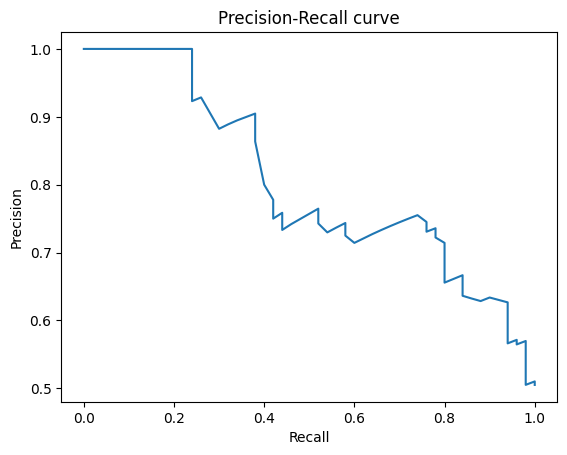

0.801800382104045


In [1]:
import numpy as np
# from scipy.integrate import simpson
import matplotlib.pyplot as plt
import warnings


def true_positives(y_true, y_pred):
    tp = 0
    for label, pred in zip(y_true, y_pred):
        if pred == 1 and label == 1:
            tp += 1
    return tp


def true_negatives(y_true, y_pred):
    tn = 0
    for label, pred in zip(y_true, y_pred):
        if pred == 0 and label == 0:
            tn += 1
    return tn


def false_positives(y_true, y_pred):
    fp = 0
    for label, pred in zip(y_true, y_pred):
        if pred == 1 and label == 0:
            fp += 1
    return fp


def false_negatives(y_true, y_pred):
    fn = 0
    for label, pred in zip(y_true, y_pred):
        if pred == 0 and label == 1:
            fn += 1
    return fn


def binary_accuracy(y_true, y_pred):
    tp = true_positives(y_true, y_pred)
    tn = true_negatives(y_true, y_pred)
    fp = false_positives(y_true, y_pred)
    fn = false_negatives(y_true, y_pred)
    return (tp + tn) / (tp + tn + fp + fn)


def precision(y_true, y_pred):
    """
    Fraction of True Positive Elements divided by total number of positive predicted units
    How I view it: Assuming we say someone has cancer: how often are we correct?
    It tells us how much we can trust the model when it predicts an individual as positive.
    """
    tp = true_negatives(y_true, y_pred)
    fp = false_positives(y_true, y_pred)
    return tp / (tp + fp)


def recall(y_true, y_pred):
    """
    Recall meaasure the model's predictive accuracy for the positive class.
    How I view it, out of all the people that has cancer: how often are
    we able to detect it?
    """
    tp = true_negatives(y_true, y_pred)
    fn = false_negatives(y_true, y_pred)
    return tp / (tp + fn)


def multiclass_accuracy(y_true, y_pred):
    correct = 0
    total = len(y_true)
    for label, pred in zip(y_true, y_pred):
        correct += label == pred
    return correct/total


def confusion_matrix(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert y_true.shape == y_pred.shape
    unique_classes = np.unique(np.concatenate([y_true, y_pred], axis=0)).shape[0]
    cm = np.zeros((unique_classes, unique_classes), dtype=np.int64)

    for label, pred in zip(y_true, y_pred):
        cm[label, pred] += 1

    return cm


def accuracy_cm(cm):
    return np.trace(cm)/np.sum(cm)


def balanced_accuracy_cm(cm):
    correctly_classified = np.diagonal(cm)
    rows_sum = np.sum(cm, axis=1)
    indices = np.nonzero(rows_sum)[0]
    if rows_sum.shape[0] != indices.shape[0]:
        warnings.warn("y_pred contains classes not in y_true")
    accuracy_per_class = correctly_classified[indices]/(rows_sum[indices])
    return np.sum(accuracy_per_class)/accuracy_per_class.shape[0]


def precision_cm(cm, average="specific", class_label=1, eps=1e-12):
    tp = np.diagonal(cm)
    fp = np.sum(cm, axis=0) - tp
    #precisions = np.diagonal(cm)/np.maximum(np.sum(cm, axis=0), 1e-12)

    if average == "none":
        return tp/(tp+fp+eps)

    if average == "specific":
        precisions = tp / (tp + fp + eps)
        return precisions[class_label]

    if average == "micro":
        # all samples equally contribute to the average,
        # hence there is a distinction between highly
        # and poorly populated classes
        return np.sum(tp) / (np.sum(tp) + np.sum(fp) + eps)

    if average == "macro":
        # all classes equally contribute to the average,
        # no distinction between highly and poorly populated classes.
        precisions = tp / (tp + fp + eps)
        return np.sum(precisions)/precisions.shape[0]

    if average == "weighted":
        pass


def recall_cm(cm, average="specific", class_label=1, eps=1e-12):
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp

    if average == "none":
        return tp / (tp + fn + eps)

    if average == "specific":
        recalls = tp / (tp + fn + eps)
        return recalls[class_label]

    if average == "micro":
        return np.sum(tp) / (np.sum(tp) + np.sum(fn))

    if average == "macro":
        recalls = tp / (tp + fn + eps)
        return np.sum(recalls)/recalls.shape[0]

    if average == "weighted":
        pass


def f1score_cm(cm, average="specific", class_label=1):
    precision = precision_cm(cm, average, class_label)
    recall = recall_cm(cm, average, class_label)
    return 2 * (precision*recall)/(precision+recall)

# true positive rate <-> sensitivity <-> recall
# true negative rate <-> specificity <-> recall for neg. class
# ROC curve
# AUC from ROC
# Precision-Recall Curve
# Log Loss
# Mattheus Correlation
# Cohen Kappa score
# --> REGRESSION METRICS


def roc_curve(y_true, y_preds, plot_graph=True, calculate_AUC=True, threshold_step=0.01):
    TPR, FPR = [], []

    for threshold in np.arange(np.min(y_preds), np.max(y_preds), threshold_step):
        predictions = (y_preds > threshold) * 1
        cm = confusion_matrix(y_true, predictions)
        recalls = recall_cm(cm, average="none")
        # note TPR == sensitivity == recall
        tpr = recalls[1]
        # note tnr == specificity (which is same as recall for the negative class)
        tnr = recalls[0]
        TPR.append(tpr)
        FPR.append(1-tnr)

    if plot_graph:
        plt.plot(FPR, TPR)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve")
        plt.show()

    if calculate_AUC:
        print(np.abs(np.trapz(TPR, FPR)))


def precision_recall_curve(y_true, y_preds, plot_graph=True, calculate_AUC=True, threshold_step=0.01):
    recalls, precisions = [], []

    for threshold in np.arange(np.min(y_preds), np.max(y_preds), threshold_step):
        predictions = (y_preds > threshold) * 1
        cm = confusion_matrix(y_true, predictions)
        recall = recall_cm(cm, average="specific", class_label=1)
        precision = precision_cm(cm, average="specific", class_label=1)
        recalls.append(recall)
        precisions.append(precision)

    recalls.append(0)
    precisions.append(1)

    if plot_graph:
        plt.plot(recalls, precisions)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall curve")
        plt.show()

    if calculate_AUC:
        print(np.abs(np.trapz(precisions, recalls)))


y = []
probs = []
with open("data.txt") as f:
    for line in f.readlines():
        label, pred = line.split()
        label = int(label)
        pred = float(pred)
        y.append(label)
        probs.append(pred)

precision_recall_curve(y, probs, threshold_step=0.001)
#from sklearn.metrics import precision_recall_curve
#precisions, recalls, _ = precision_recall_curve(y, probs)
#plt.plot(recalls, precisions)
#plt.xlabel("Recall")
#plt.ylabel("Precision")
#plt.title("Precision-Recall curve")
#plt.show()
#print(np.abs(np.trapz(precisions, recalls)))


